In [1]:
%load_ext autoreload

In [34]:
%autoreload 2
import cmath
from kneed import KneeLocator
from nolitsa import delay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import DBSCAN, KMeans
import sys

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from dynamical_systems_models import *

# Class and Sparse

In [6]:
def sparsify_dynamics(Theta, dXdt, lamb, num_its=10):
    n = dXdt.shape[1]
    # compute Sparse regression: sequential least squares
    Xi = np.linalg.lstsq(Theta, dXdt, rcond=1e-14)[0] #  initial guess: Least-squares
    
    for i in range(num_its):
        smallinds = np.abs(Xi) < lamb  # find small coefficients
        Xi[smallinds] = 0               # and threshold
        for ind in range(n):            # n is state dimension
            biginds = ~smallinds[:,ind]
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds], dXdt[:,ind], rcond=1e-14)[0]
    
    return Xi

class HavokModel:
    def __init__(self, signal, dt):
        self.signal = signal
        self.dt = dt
        
        self.T = signal.shape[0]
        self.N = signal.shape[1]
        
        self.sparse = None
        self.p = None
        self.H = None
        self.U = None
        self.S = None
        self.V = None
        self.r = None
        self.S_mat = None
        self.S_mat_inv = None
        self.project_up = None
        self.project_down = None
        self.A = None
        self.B = None
        self.x = None
        self.dx = None
    
    def fit(self, p, r=4, sparse=False, lamb=0, rcond=1e-14, verbose=False):
        self.sparse = sparse
        # embed the signal in a delay embedding space to create a Hankel matrix
        if self.p == p:
            if verbose:
                print('Delay embedding already created! Also have already performed SVD!')
        else:
            if verbose:
                print('Creating the delay embedding...')
            self.p = p
            H = embed_signal(self.signal, p, 1, direction='reverse')
#             H = embed_signal(self.signal, p, 1, direction='forward')
            self.H = H
        
            # perform SVD on Hankel matrix
            if verbose:
                print("Delay embedding created! Performing SVD...")
            U, S, Vh = np.linalg.svd(H.T, full_matrices=False)
            self.U = U
            self.S = S
            V = Vh.T
            self.V = V
            
            # create the singular value matrix for reconstruction and decomposition
            S_mat = np.zeros((U.shape[1], len(S)))
            S_mat_inv = np.zeros((len(S), U.shape[1]))
            S_mat[np.arange(len(S)), np.arange(len(S))] = S
            S_mat_inv[np.arange(len(S)), np.arange(len(S))] = 1/S
            self.S_mat = S_mat
            self.S_mat_inv = S_mat_inv
            self.project_up = U @ S_mat
            self.project_down = S_mat_inv @ U.T
#             self.project_up = U
#             self.project_down = U.T
        
        # pick the eigen-delay embedding coordinate dimension r
        if verbose:
            print("SVD complete! Picking eigen-time-delay coordinate dimension r...")
        self.r = r

        # find least squares solution to prediction problem (DMD)
        if sparse:
            if verbose:
                print("Picked eigen-time-delay coordinate dimension r! Now performing sparse fit: computing derivatives...")

            dV = np.zeros((self.V.shape[0] - 5, r))
            for t in tqdm(range(2, self.V.shape[0] - 3), disable=not verbose):
                for k in range(r):
                    dV[t-2,k] = (1/(12*dt))*(-self.V[t+2,k]+8*self.V[t+1,k]-8*self.V[t-1,k]+self.V[t-2,k])
            
            if verbose:
                print("Derivatives computed! Now computing sparse fit...")
            
            x = self.V[2:-3]
            self.x = x
            dx = dV
            self.dx = dx

            Theta = PolynomialFeatures(degree=1).fit_transform(x[:, :r])
            normTheta = np.linalg.norm(Theta, axis=0)
            Theta = np.divide(Theta, normTheta)
            
            if lamb == 0:
                Xi = np.linalg.lstsq(Theta, dx[:, :r-1], rcond=rcond)[0]
            else:
                Xi = np.zeros((Theta.shape[1], r - 1))
                for k in tqdm(range(r-1), disable=not verbose):
                    Xi[:, [k]] = sparsify_dynamics(Theta, dx[:, [k]], lamb)
            Xi = np.divide(Xi.T, normTheta).T
            Xi_temp = Xi[1:(r+1), :r-1].T
            A = Xi_temp[:, :r-1]
            B = Xi_temp[:, [r-1]]
            
            if verbose:
                print("Sparse fit computed!")
            
        else:
            if verbose:
                print("Picked eigen-time-delay coordinate dimension r! Now performing least squares fit...")

            X = self.V[:-1, :r]
            X_prime = self.V[1:, :r]
            Xi, residuals, rank, s = np.linalg.lstsq(X, X_prime, rcond=rcond)
            Xi = Xi.T

            A = Xi[:r-1, :r-1]
            B = Xi[:r-1, [r-1]]
            
            if verbose:
                print("Least squares fit complete!")
        
        if verbose:
            print("All done!")
        
        self.A = A
        self.B = B
        
        
    
    def predict(self, x0, num_steps, v_r=None, verbose=False):
        if x0.shape[0] != self.p or x0.shape[1] != self.N:
            raise ValueError(f"x0 must have shape {(self.p, self.N)}; currently has shape {x0.shape}")
        
        h = embed_signal(x0, self.p, 1, direction='reverse')[0]
#         h = embed_signal(x0, self.p, 1, direction='forward')[0]
    
        if self.sparse:
            x0 = self.project_down[:self.r - 1, :] @ h
            sys = scipy.signal.lti(self.A, self.B, np.eye(self.r-1), np.zeros(self.B.shape))
            T, yout, xout = scipy.signal.lsim(sys, v_r, np.arange(num_steps)*self.dt, x0)
            
            v_out = yout
            preds = ((self.project_up[:, :self.r - 1] @ v_out.T).T)[:, :self.N]
            
            h_out = None
            
        else:
            if v_r is not None:
                if len(v_r) < num_steps - 1:
                    raise ValueError(f"Length of v_r is {len(v_r)}; was expecting at least {num_steps - 1}")

                v_out = np.zeros((num_steps, self.r - 1))
                v_out[0] = self.project_down[:self.r - 1, :] @ h
                for t in tqdm(range(1, num_steps), disable=not verbose):
                    v_out[t] = self.A @ v_out[t - 1] + self.B[:, 0] * v_r[t - 1]

                preds = ((self.project_up[:, :self.r - 1] @ v_out.T).T)[:, :self.N]

                h_out = None

            else: # v_r is None
                v_out = np.zeros((num_steps, self.r))
                h_out = np.zeros((num_steps, len(h)))
                h_out[0] = h
                v_out[0] = self.project_down[:self.r, :] @ h
                preds = np.zeros((num_steps, self.N))
                preds[0] = h[:self.N]

                for t in tqdm(range(1, num_steps), disable=not verbose):
                    v_out[t, :self.r - 1] = self.A @ v_out[t - 1, :self.r - 1] + self.B[:, 0] * v_out[t - 1, self.r - 1]
                    h_prev = h
                    h = np.zeros(len(h))
                    h[:self.N] = (self.project_up[:, :r-1] @ v_out[t, :self.r - 1])[:self.N]
                    preds[t] = h[:self.N]
                    h[self.N:] = h_prev[:-self.N]
                    h_out[t] = h
                    v_out[t, self.r - 1] = (self.project_down @ h)[self.r - 1]
            
        return preds, v_out, h_out

In [237]:
# lorenz_data = loadmat('/om/user/eisenaj/datasets/HAVOK_data/lorenz_data.mat')
# full_signal = lorenz_data['xdat'][:, [0]]

sleep_data = loadmat('/om/user/eisenaj/datasets/HAVOK_data/sleep_data.mat')

full_signal = sleep_data['sleepeeg'].T[:int(1e6), [0, 1]]

dt_orig = 0.001

  0%|          | 0/200 [00:00<?, ?it/s]

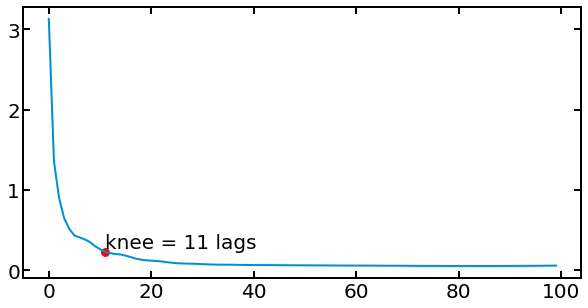

In [238]:
# dt = dt_orig
# train_boundary = int(1e5)
# train_signal = full_signal[:train_boundary]

# downsample
num_lags = 100
delayed_mi = np.zeros((full_signal.shape[1], num_lags))
iterator = tqdm(total=full_signal.shape[1]*num_lags)
for i in range(full_signal.shape[1]):
    for lag in range(num_lags):
        delayed_mi[i, lag] = delay.mi(full_signal[lag:, i], full_signal[:full_signal.shape[0] - lag, i])
        iterator.update()
iterator.close()

mean_delayed_mi = delayed_mi.mean(axis=0)

kneed = KneeLocator(np.arange(delayed_mi.shape[1]), mean_delayed_mi, curve='convex', direction='decreasing')

start = 0
end = 100
plt.plot(np.arange(num_lags)[start:end], mean_delayed_mi[start:end])
plt.scatter(kneed.knee, mean_delayed_mi[kneed.knee], c='r', s=60)
plt.text(kneed.knee, mean_delayed_mi[kneed.knee]*1.2, f'knee = {kneed.knee} lags')
plt.show()

In [239]:
dt = dt_orig*kneed.knee
full_signal_downsampled = full_signal[np.arange(0, full_signal.shape[0], kneed.knee)]
# train_boundary = int(300/dt) # s to time steps
train_boundary = int(100/dt) # s to time steps
train_signal = full_signal_downsampled[:train_boundary]

In [240]:
# SIMULATE
# havok = HavokModel(signal=lorenz_data['xdat'][:, [0]], dt=dt)
havok = HavokModel(signal=train_signal, dt=dt)

p = 1000
# p = 100

In [241]:
havok.fit(p, r = 1000, sparse=True, verbose=True)

Creating the delay embedding...
Delay embedding created! Performing SVD...
SVD complete! Picking eigen-time-delay coordinate dimension r...
Picked eigen-time-delay coordinate dimension r! Now performing sparse fit: computing derivatives...


  0%|          | 0/8086 [00:00<?, ?it/s]

Derivatives computed! Now computing sparse fit...
Sparse fit computed!
All done!


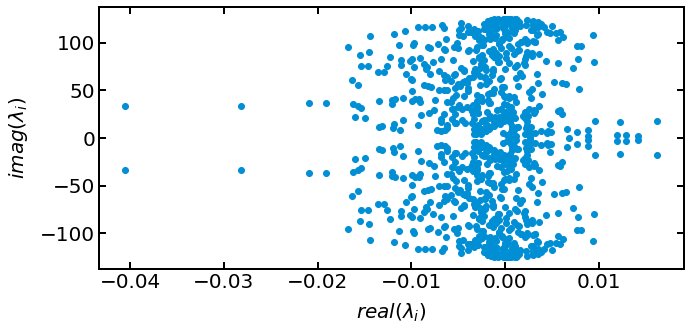

In [242]:
eigvals = np.linalg.eigvals(havok.A)
plt.scatter(np.real(eigvals), np.imag(eigvals))
plt.xlabel(r'$real(\lambda_i)$')
plt.ylabel(r'$imag(\lambda_i)$')
plt.tight_layout()
plt.show()

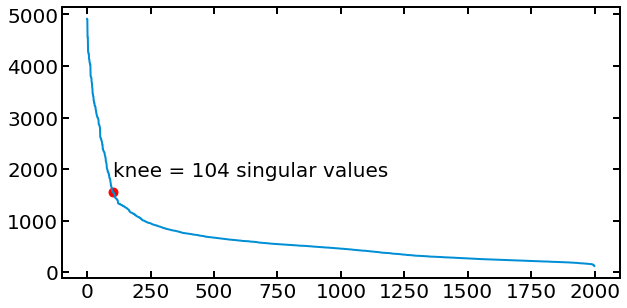

In [243]:
knee = KneeLocator(np.arange(len(havok.S)), havok.S, S=1, curve='convex', direction='decreasing').knee
plt.plot(havok.S)
plt.scatter(knee, havok.S[knee], c='r', s=80)
plt.text(knee, havok.S[knee]*1.2, f"knee = {knee + 1} singular values")
plt.show()

In [296]:
havok.fit(p, r = knee*6, sparse=True, verbose=True)

Delay embedding already created! Also have already performed SVD!
SVD complete! Picking eigen-time-delay coordinate dimension r...
Picked eigen-time-delay coordinate dimension r! Now performing sparse fit: computing derivatives...


  0%|          | 0/8086 [00:00<?, ?it/s]

Derivatives computed! Now computing sparse fit...
Sparse fit computed!
All done!


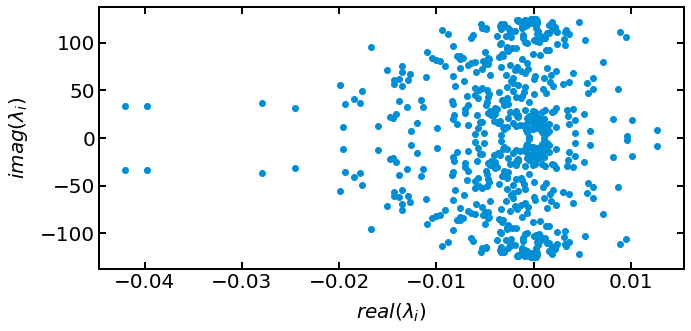

In [297]:
eigvals = np.linalg.eigvals(havok.A)
plt.scatter(np.real(eigvals), np.imag(eigvals))
plt.xlabel(r'$real(\lambda_i)$')
plt.ylabel(r'$imag(\lambda_i)$')
plt.tight_layout()
plt.show()

### Prediction on Training

In [298]:
preds, v_out, h_out = havok.predict(havok.signal[:havok.p], num_steps=havok.V.shape[0], v_r=havok.V[:, havok.r - 1])

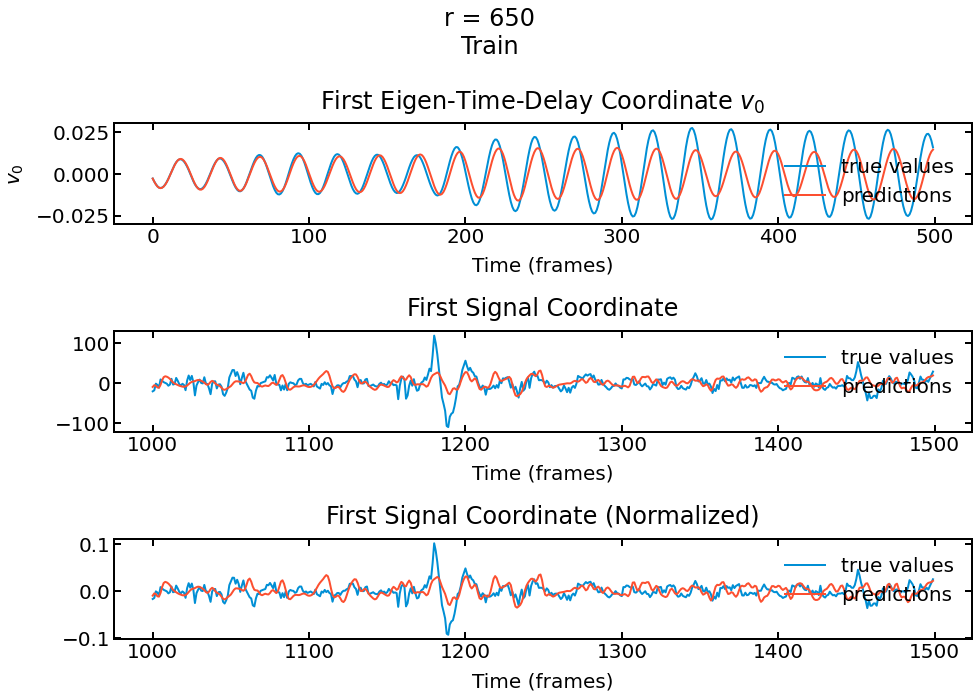

In [299]:
plt.figure(figsize=(14, 10))
start = 0
end = 500
plt.subplot(3, 1, 1)
plt.plot(havok.V[start:end, 0], label='true values')
plt.plot(v_out[start:end, 0], label='predictions')
plt.legend()
plt.xlabel('Time (frames)')
plt.ylabel('$v_0$')
plt.title('First Eigen-Time-Delay Coordinate $v_0$')
plt.subplot(3, 1, 2)
plt.plot(np.arange(havok.p + start, havok.p + end), havok.signal[start + havok.p:end + havok.p, 0], label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 0], label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(np.arange(havok.p + start, havok.p + end), havok.signal[start + havok.p:end + havok.p, 0]/np.linalg.norm(havok.signal[:, 0]), label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 0]/np.linalg.norm(preds[:, 0]), label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate (Normalized)')
plt.legend()
plt.suptitle(f"r = {r}\nTrain")
plt.tight_layout()

plt.show()

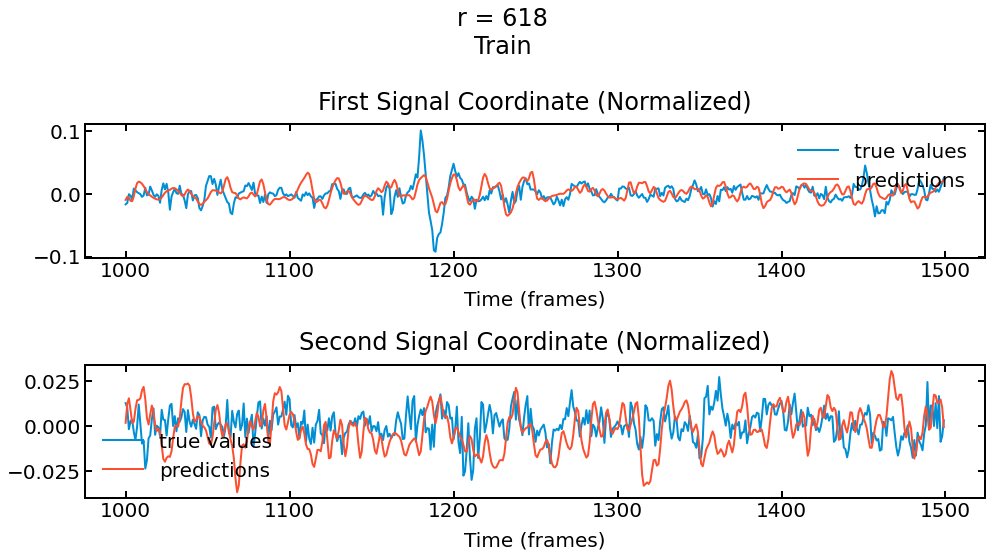

In [301]:
plt.figure(figsize=(14, 8))
start = 0
end = 500
plt.subplot(2, 1, 1)
plt.plot(np.arange(havok.p + start, havok.p + end), havok.signal[start + havok.p:end + havok.p, 0]/np.linalg.norm(havok.signal[:, 0]), label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 0]/np.linalg.norm(preds[:, 0]), label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate (Normalized)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.arange(havok.p + start, havok.p + end), havok.signal[start + havok.p:end + havok.p, 1]/np.linalg.norm(havok.signal[:, 1]), label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 1]/np.linalg.norm(preds[:, 1]), label='predictions')
plt.xlabel('Time (frames)')
plt.title('Second Signal Coordinate (Normalized)')
plt.legend()
plt.suptitle(f"r = {havok.r}\nTrain")
plt.tight_layout()

plt.show()

### Forward Prediction

In [302]:
T_pred = 500
test_data = full_signal_downsampled[train_boundary - havok.p:train_boundary + T_pred]

v_test = (havok.project_down[:havok.r, :] @ embed_signal(test_data, havok.p, 1, direction='reverse').T).T
v_r = v_test[:, [havok.r - 1]]

preds, v_out, h_out = havok.predict(test_data[:havok.p], num_steps=T_pred, v_r=v_r[:-1])

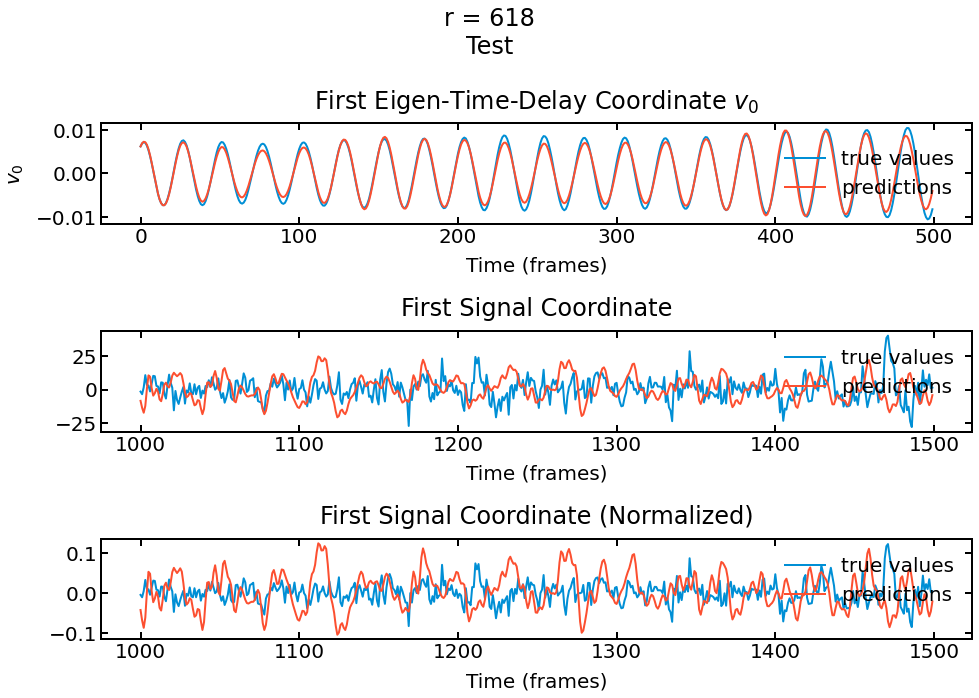

In [303]:
plt.figure(figsize=(14, 10))
start = 0
end = 500
plt.subplot(3, 1, 1)
plt.plot(v_test[start:end, 0], label='true values')
plt.plot(v_out[start:end, 0], label='predictions')
plt.legend()
plt.xlabel('Time (frames)')
plt.ylabel('$v_0$')
plt.title('First Eigen-Time-Delay Coordinate $v_0$')
plt.subplot(3, 1, 2)
plt.plot(np.arange(havok.p + start, havok.p + end), test_data[start + havok.p:end + havok.p, 0], label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 0], label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(np.arange(havok.p + start, havok.p + end), test_data[start + havok.p:end + havok.p, 0]/np.linalg.norm(test_data[:, 0]), label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 0]/np.linalg.norm(preds[:, 0]), label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate (Normalized)')
plt.legend()
plt.suptitle(f"r = {havok.r}\nTest")
plt.tight_layout()
plt.show()

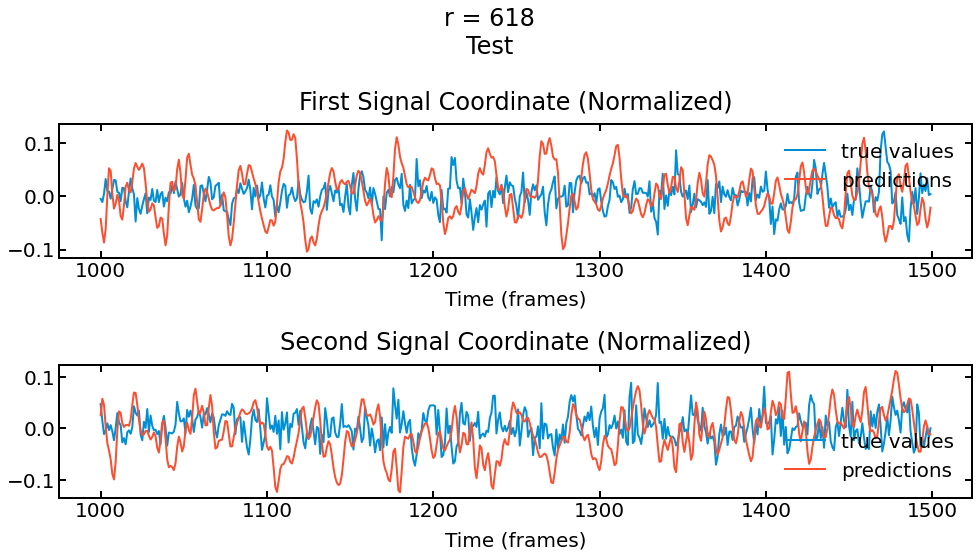

In [305]:

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(havok.p + start, havok.p + end), test_data[start + havok.p:end + havok.p, 0]/np.linalg.norm(test_data[:, 0]), label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 0]/np.linalg.norm(preds[:, 0]), label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate (Normalized)')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(np.arange(havok.p + start, havok.p + end), test_data[start + havok.p:end + havok.p, 1]/np.linalg.norm(test_data[:, 1]), label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), preds[start:end, 1]/np.linalg.norm(preds[:, 1]), label='predictions')
plt.xlabel('Time (frames)')
plt.title('Second Signal Coordinate (Normalized)')
plt.legend()
plt.suptitle(f"r = {havok.r}\nTest")
plt.tight_layout()
plt.show()

In [306]:
def autocorrel(signal, lags=50):
    autocorrel = np.zeros(lags)
    for lag in range(lags):
        autocorrel[lag] = scipy.stats.pearsonr(signal[lag:], signal[:signal.shape[0] - lag])[0]
    
    return autocorrel

In [307]:
lags = 50
true_autocorrel = np.zeros((test_data.shape[1], lags))
pred_autocorrel = np.zeros((test_data.shape[1], lags))
for i in range(test_data.shape[1]):
    true_autocorrel[i, :] = autocorrel(test_data[havok.p:, i], lags=lags)
    pred_autocorrel[i, :] = autocorrel(preds[:, i], lags=lags)

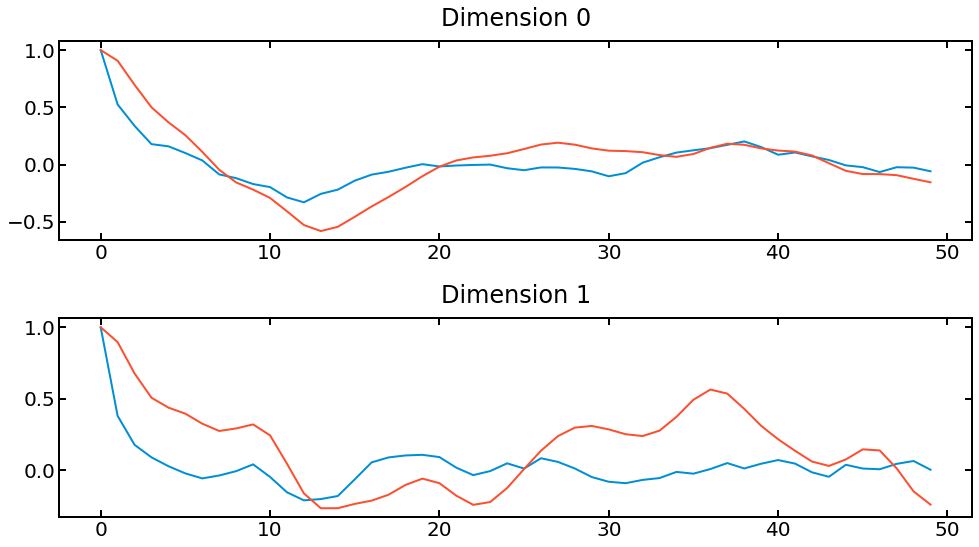

In [308]:
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.title('Dimension 0')
plt.plot(true_autocorrel[0])
plt.plot(pred_autocorrel[0])

plt.subplot(2, 1, 2)
plt.title('Dimension 1')
plt.plot(true_autocorrel[1])
plt.plot(pred_autocorrel[1])
plt.tight_layout()
plt.show()

# Errors

In [197]:
def compute_error(mat1, mat2, normed=True):
    err = np.sqrt(((mat1 - mat2)**2).sum())
    if normed:
        return err/np.sqrt((mat2**2).sum())
    else:
        return err

In [311]:
T_pred = 500
test_data = full_signal_downsampled[train_boundary - havok.p:train_boundary + T_pred]
normed_test_data = np.divide(test_data, np.linalg.norm(test_data, axis=0))
v_test = (havok.project_down @ embed_signal(test_data, havok.p, 1, direction='reverse').T).T

true_autocorrel = np.zeros((test_data.shape[1], lags))
for i in range(test_data.shape[1]):
        true_autocorrel[i, :] = autocorrel(test_data[havok.p:, i], lags=lags)

In [316]:
rets = []
# r_vals = np.arange(4, 25)
# r_vals = np.array([5, 10, 15, 20, 25, 30, 40, 50, 60, 60, 80, 90, 100, 120, 140, 160, 180, 200, 225, 250, 275, 300, 325, 350, 375, 400, 450, 500, 550, 600, 650])
r_vals = np.arange(1, 7)*knee
for r in tqdm(r_vals):
    havok.fit(p, r = r, sparse=True)
    # TRAIN
#     preds, v_out, h_out = havok.predict(havok.signal[:havok.p], num_steps=havok.V.shape[0], v_r=havok.V[:, havok.r - 1])

#     error_v0 = compute_error(v_out[:, 0], havok.V[:, 0])
#     error_3vs = compute_error(v_out[:, :3], havok.V[:, :3])
#     error_rvs = compute_error(v_out[:, :havok.r - 1], havok.V[:, :havok.r - 1])
#     error_preds = compute_error(preds[:-1], havok.signal[havok.p:])

    # TEST
    v_r = v_test[:, havok.r - 1]
    preds, v_out, h_out = havok.predict(test_data[:havok.p], num_steps=T_pred, v_r=v_r[:-1])
    
    error_v0 = compute_error(v_out[:, 0], v_test[:-1, 0])
    error_3vs = compute_error(v_out[:, :3], v_test[:-1, :3])
    error_rvs = compute_error(v_out[:, :havok.r - 1], v_test[:-1, :havok.r - 1])
    error_preds = compute_error(preds, test_data[havok.p:])
    normed_preds =  preds/np.linalg.norm(preds)
    error_normed_preds = compute_error(normed_preds, normed_test_data[havok.p:])
    
    lags = 50
    
    pred_autocorrel = np.zeros((test_data.shape[1], lags))
    for i in range(test_data.shape[1]):
        pred_autocorrel[i, :] = autocorrel(preds[:, i], lags=lags)
        
    error_autocorrel = compute_error(pred_autocorrel, true_autocorrel)
    
    rets.append(dict(
        preds=preds,
        v_out=v_out,
        h_out=h_out,
        error_v0=error_v0,
        error_3vs=error_3vs,
        error_rvs=error_rvs,
        error_preds=error_preds,
        error_normed_preds=error_normed_preds,
        error_autocorrel=error_autocorrel,
    ))

  0%|          | 0/6 [00:00<?, ?it/s]

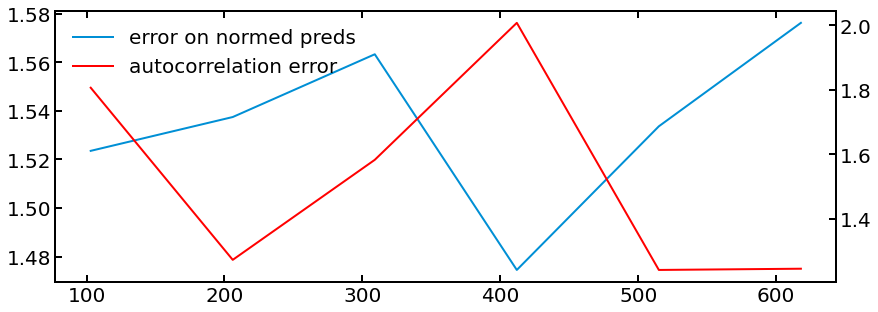

In [321]:
start = 0
end = len(r_vals)
plt.figure(figsize=(14, 5))
# plt.plot(r_vals[start:end], [ret['error_v0'] for ret in rets][start:end], label='error on $v_0$')
# plt.plot(r_vals[start:end], [ret['error_3vs'] for ret in rets][start:end], label='error on $v_0$ through $v_2$')
# plt.plot(r_vals[start:end], [ret['error_rvs'] for ret in rets][start:end], label='error on $v_0$ through $v_{r-1}$')
# plt.plot(r_vals[start:end], [ret['error_preds'] for ret in rets][start:end], label='error on preds')
ln1 = plt.plot(r_vals[start:end], [ret['error_normed_preds'] for ret in rets][start:end], label='error on normed preds')
ax = plt.gca()
ax2 = ax.twinx()
ln2 = ax2.plot(r_vals[start:end], [ret['error_autocorrel'] for ret in rets][start:end], c='r', label='autocorrelation error')
plt.xlabel('$r$')
lns = ln1 + ln2
labels = [ln.get_label() for ln in lns]
plt.legend(lns, labels)
plt.show()

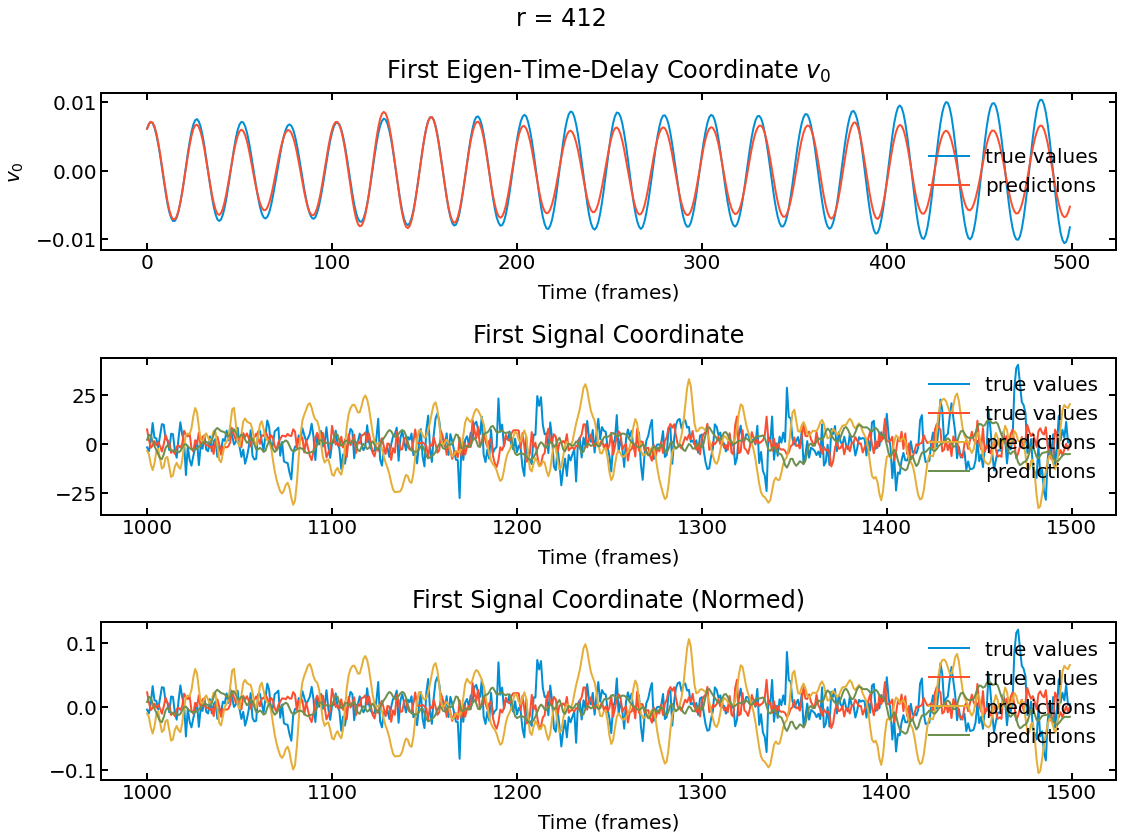

In [322]:
r = knee*4

start = 0
end = 500
plt.figure(figsize=(16, 12))
plt.subplot(3, 1, 1)
plt.plot(np.arange(start, end), v_test[start:end, 0], label='true values')
plt.plot(np.arange(start, end), rets[np.where(r_vals == r)[0][0]]['v_out'][start:end, 0], label='predictions')
plt.xlabel('Time (frames)')
plt.ylabel('$v_0$')
plt.title('First Eigen-Time-Delay Coordinate $v_0$')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(np.arange(havok.p + start, havok.p + end), test_data[havok.p + start:havok.p + end], label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), rets[np.where(r_vals == r)[0][0]]['preds'][start:end], label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(np.arange(havok.p + start, havok.p + end), test_data[havok.p + start:havok.p + end]/np.linalg.norm(test_data[:, 0]), label='true values')
plt.plot(np.arange(havok.p + start, havok.p + end), rets[np.where(r_vals == r)[0][0]]['preds'][start:end]/np.linalg.norm(rets[np.where(r_vals == r)[0][0]]['preds']), label='predictions')
plt.xlabel('Time (frames)')
plt.title('First Signal Coordinate (Normed)')
plt.legend()
plt.suptitle(f"r = {r}")
plt.tight_layout()
plt.show()

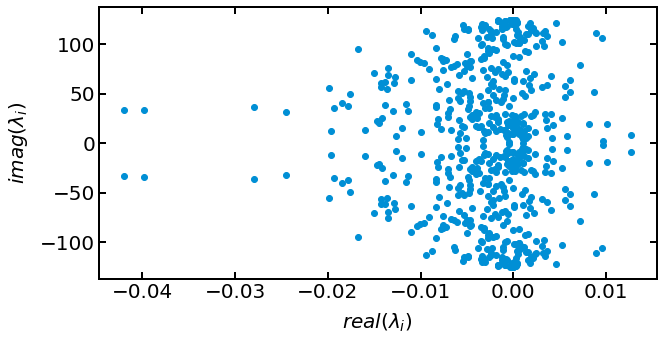

In [323]:
eigvals = np.linalg.eigvals(havok.A)
plt.scatter(np.real(eigvals), np.imag(eigvals))
plt.xlabel(r'$real(\lambda_i)$')
plt.ylabel(r'$imag(\lambda_i)$')
plt.show()